In [92]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.
Class names: ['damage', 'no_damage']
Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)
damage: 11353 images (66.56%)
no_damage: 5705 images (33.44%)


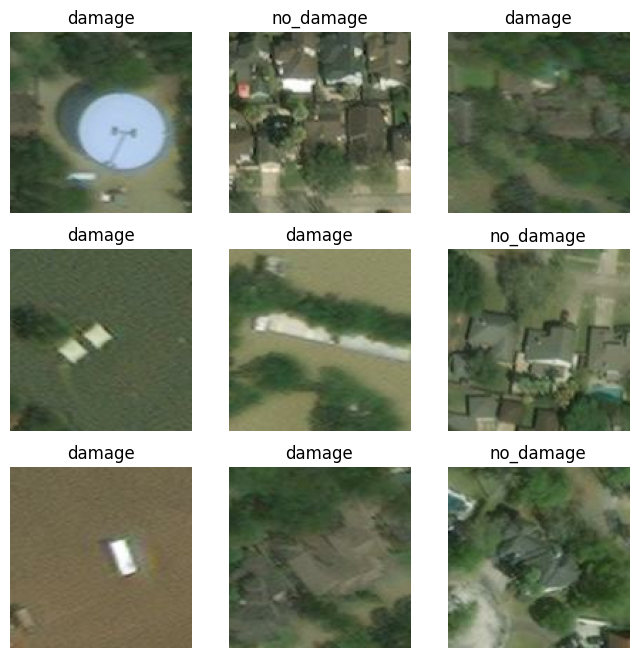

In [69]:
data_dir = 'datasets-unit03_Project2'
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  seed=42,
  image_size=(128, 128),
  batch_size=32
)
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=42,
  image_size=(128, 128),
  batch_size=32
)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f'Class names: {train_ds.class_names}')

for images, labels in train_ds.take(1):
  print('Image batch shape:', images.shape)
  print('Label batch shape:', labels.shape)

damage_count = 0
no_damage_count = 0

for _, labels in train_ds:
  damage_count += np.sum(labels.numpy() == 0)
  no_damage_count += np.sum(labels.numpy() == 1)

total = damage_count + no_damage_count
print(f"damage: {damage_count} images ({damage_count / total * 100:.2f}%)")
print(f"no_damage: {no_damage_count} images ({no_damage_count / total * 100:.2f}%)")

class_weights_arr = compute_class_weight(
  class_weight='balanced',
  classes=np.array([0, 1]),
  y=[0] * damage_count + [1] * no_damage_count
)
class_weights = dict(enumerate(class_weights_arr))

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')
plt.show()

In [71]:
def preprocess_grayscale_ann(ds):
    ds = ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x) / 255.0, y))
    return ds

def preprocess_color_ann(ds):
    ds = ds.map(lambda x, y: (x / 255.0, y))
    return ds

light_aug = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomBrightness(0.05)
])

moderate_aug = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomBrightness(0.05)
])

heavy_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

def preprocess_lenet_no_aug(ds):
    ds = ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x) / 255.0, y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [28, 28]), y))
    return ds

def preprocess_lenet_light_aug(ds):
    ds = preprocess_lenet_no_aug(ds)
    ds = ds.map(lambda x, y: (light_aug(x, training=True), y))
    return ds

def preprocess_lenet_moderate_aug(ds):
    ds = preprocess_lenet_no_aug(ds)
    ds = ds.map(lambda x, y: (moderate_aug(x, training=True), y))
    return ds

def preprocess_modified_lenet_no_aug(ds):
    ds = ds.map(lambda x, y: (x/255.0, y))
    ds = ds.map(lambda x, y: (tf.image.resize(x, [150, 150]), y))
    return ds

def preprocess_modified_lenet_light_aug(ds):
    ds = preprocess_modified_lenet_no_aug(ds)
    ds = ds.map(lambda x, y: (light_aug(x, training=True), y))
    return ds

def preprocess_modified_lenet_moderate_aug(ds):
    ds = preprocess_modified_lenet_no_aug(ds)
    ds = ds.map(lambda x, y: (moderate_aug(x, training=True), y))
    return ds

def preprocess_modified_lenet_heavy_aug(ds):
    ds = preprocess_modified_lenet_no_aug(ds)
    ds = ds.map(lambda x, y: (heavy_aug(x, training=True), y))
    return ds

def preprocess_vgg_no_aug(ds):
    ds = ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    return ds

def preprocess_vgg_light_aug(ds):
    ds = ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
    ds = ds.map(lambda x, y: (light_aug(x, training=True), y))
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    return ds

def preprocess_vgg_moderate_aug(ds):
    ds = ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
    ds = ds.map(lambda x, y: (moderate_aug(x, training=True), y))
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    return ds

def preprocess_vgg_heavy_aug(ds):
    ds = ds.map(lambda x, y: (tf.image.resize(x, [224, 224]), y))
    ds = ds.map(lambda x, y: (heavy_aug(x, training=True), y))
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    return ds

In [72]:
def cache(ds, shuffle=False):
  return ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) if shuffle else ds.cache().prefetch(buffer_size=AUTOTUNE)

train_grayscale_ann_ds = cache(preprocess_grayscale_ann(train_ds), shuffle=True)
val_grayscale_ann_ds = cache(preprocess_grayscale_ann(val_ds))
test_grayscale_ann_ds = cache(preprocess_grayscale_ann(test_ds))

train_color_ann_ds = cache(preprocess_color_ann(train_ds), shuffle=True)
val_color_ann_ds = cache(preprocess_color_ann(val_ds))
test_color_ann_ds = cache(preprocess_color_ann(test_ds))

train_lenet_no_aug_ds = cache(preprocess_lenet_no_aug(train_ds), shuffle=True)
train_lenet_light_aug_ds = cache(preprocess_lenet_light_aug(train_ds), shuffle=True)
train_lenet_moderate_aug_ds = cache(preprocess_lenet_moderate_aug(train_ds), shuffle=True)
val_lenet_ds = cache(preprocess_lenet_no_aug(val_ds))
test_lenet_ds = cache(preprocess_lenet_no_aug(test_ds))

train_mod_lenet_no_aug_ds = cache(preprocess_modified_lenet_no_aug(train_ds), shuffle=True)
train_mod_lenet_light_aug_ds = cache(preprocess_modified_lenet_light_aug(train_ds), shuffle=True)
train_mod_lenet_moderate_aug_ds = cache(preprocess_modified_lenet_moderate_aug(train_ds), shuffle=True)
train_mod_lenet_heavy_aug_ds = cache(preprocess_modified_lenet_heavy_aug(train_ds), shuffle=True)
val_mod_lenet_ds = cache(preprocess_modified_lenet_no_aug(val_ds))
test_mod_lenet_ds = cache(preprocess_modified_lenet_no_aug(test_ds))

train_vgg_no_aug_ds = cache(preprocess_vgg_no_aug(train_ds), shuffle=True)
train_vgg_light_aug_ds = cache(preprocess_vgg_light_aug(train_ds), shuffle=True)
train_vgg_moderate_aug_ds = cache(preprocess_vgg_moderate_aug(train_ds), shuffle=True)
train_vgg_heavy_aug_ds = cache(preprocess_vgg_heavy_aug(train_ds), shuffle=True)
val_vgg_ds = cache(preprocess_vgg_no_aug(val_ds))
test_vgg_ds = cache(preprocess_vgg_no_aug(test_ds))

In [73]:
def create_grayscale_ann():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_color_ann():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_lenet():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(6, (5, 5), activation='tanh', padding='same'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), activation='tanh'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='tanh'),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_modified_lenet():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_vgg16():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  base_model.trainable = False
  model = tf.keras.Sequential([
      base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_vgg19():
  base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  base_model.trainable = False
  model = tf.keras.Sequential([
      base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [74]:
def train_model(model, train_ds, val_ds, test_ds):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weights
    )
    y_pred = model.predict(test_ds)
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()
    print(f'Unique predictions: {np.unique(y_pred_labels, return_counts=True)}')
    y_true = np.concatenate([y for _, y in test_ds], axis=0).flatten()
    f1 = f1_score(y_true, y_pred_labels)
    print(f'F1 score: {f1}')
    return model

In [75]:
train_model(create_grayscale_ann(), train_grayscale_ann_ds, val_grayscale_ann_ds, test_grayscale_ann_ds)
train_model(create_color_ann(), train_color_ann_ds, val_color_ann_ds, test_color_ann_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5517 - loss: 1.2005 - val_accuracy: 0.5774 - val_loss: 0.6621
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6175 - loss: 0.6515 - val_accuracy: 0.7184 - val_loss: 0.6318
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6544 - loss: 0.6367 - val_accuracy: 0.7127 - val_loss: 0.5894
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6687 - loss: 0.6590 - val_accuracy: 0.6670 - val_loss: 0.6382
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6211 - loss: 0.6711 - val_accuracy: 0.5316 - val_loss: 0.6701
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6049 - loss: 0.6716 - val_accuracy: 0.5401 - val_loss: 0.6709
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6333 - loss: 0.6526 - val_accuracy: 0.6561 - val_loss: 0.6392
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6538 - loss: 0.6464 - val_acc

<Sequential name=sequential_41, built=True>

The above models had F1 scores of .36 and .66, respectively, which suggests that color carries important detail for these models.

In [76]:
train_model(create_lenet(), train_lenet_no_aug_ds, val_lenet_ds, test_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6310 - loss: 0.6436 - val_accuracy: 0.6948 - val_loss: 0.5960
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6784 - loss: 0.6120 - val_accuracy: 0.6245 - val_loss: 0.6506
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6756 - loss: 0.5927 - val_accuracy: 0.6892 - val_loss: 0.5554
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6873 - loss: 0.5718 - val_accuracy: 0.6637 - val_loss: 0.5964
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7086 - loss: 0.5525 - val_accuracy: 0.6613 - val_loss: 0.5920
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7173 - loss: 0.5379 - val_accuracy: 0.7184 - val_loss: 0.5443
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7359 - loss: 0.5285 - val_accuracy: 0.7368 - val_loss: 0.5331
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7289 - loss: 0.5257 - val_accuracy: 0.

<Sequential name=sequential_42, built=True>

In [77]:
train_model(create_lenet(), train_lenet_light_aug_ds, val_lenet_ds, test_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4678 - loss: 0.7021 - val_accuracy: 0.3335 - val_loss: 0.7320
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4885 - loss: 0.6949 - val_accuracy: 0.6651 - val_loss: 0.6875
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4948 - loss: 0.6940 - val_accuracy: 0.6646 - val_loss: 0.6288
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4958 - loss: 0.6935 - val_accuracy: 0.3363 - val_loss: 0.7549
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4989 - loss: 0.6948 - val_accuracy: 0.6693 - val_loss: 0.6452
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5132 - loss: 0.6931 - val_accuracy: 0.6698 - val_loss: 0.6254
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5248 - loss: 0.6919 - val_accuracy: 0.5703 - val_loss: 0.6701
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5410 - loss: 0.6886 - val_accuracy: 0.

<Sequential name=sequential_43, built=True>

In [78]:
train_model(create_lenet(), train_lenet_moderate_aug_ds, val_lenet_ds, test_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4678 - loss: 0.7075 - val_accuracy: 0.3307 - val_loss: 0.7655
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5207 - loss: 0.6951 - val_accuracy: 0.6693 - val_loss: 0.6712
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5258 - loss: 0.6947 - val_accuracy: 0.3566 - val_loss: 0.7021
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5304 - loss: 0.6943 - val_accuracy: 0.6693 - val_loss: 0.6713
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5200 - loss: 0.6972 - val_accuracy: 0.6712 - val_loss: 0.6666
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5273 - loss: 0.6935 - val_accuracy: 0.6684 - val_loss: 0.6775
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4925 - loss: 0.6946 - val_accuracy: 0.3307 - val_loss: 0.7264
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5207 - loss: 0.6946 - val_accuracy: 0.

<Sequential name=sequential_44, built=True>

In [80]:
train_model(create_modified_lenet(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 87s 162ms/step - accuracy: 0.6676 - loss: 0.5704 - val_accuracy: 0.8226 - val_loss: 0.3289
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 160ms/step - accuracy: 0.9081 - loss: 0.2209 - val_accuracy: 0.9330 - val_loss: 0.1646
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9379 - loss: 0.1662 - val_accuracy: 0.9387 - val_loss: 0.1492
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 160ms/step - accuracy: 0.9465 - loss: 0.1407 - val_accuracy: 0.9415 - val_loss: 0.1472
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9589 - loss: 0.1063 - val_accuracy: 0.9358 - val_loss: 0.1696
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9619 - loss: 0.0988 - val_accuracy: 0.9453 - val_loss: 0.1302
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 160ms/step - accuracy: 0.9567 - loss: 0.1151 - val_accuracy: 0.9382 - val_loss: 0.1522
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9664 - loss: 0

<Sequential name=sequential_46, built=True>

In [81]:
train_model(create_modified_lenet(), train_mod_lenet_light_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 97s 159ms/step - accuracy: 0.4897 - loss: 0.7277 - val_accuracy: 0.6708 - val_loss: 0.6917
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.4371 - loss: 0.6933 - val_accuracy: 0.6708 - val_loss: 0.6925
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.5906 - loss: 0.6936 - val_accuracy: 0.3292 - val_loss: 0.6935
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 84s 157ms/step - accuracy: 0.3665 - loss: 0.6937 - val_accuracy: 0.3292 - val_loss: 0.6933
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 84s 158ms/step - accuracy: 0.5000 - loss: 0.6935 - val_accuracy: 0.6708 - val_loss: 0.6926
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 84s 157ms/step - accuracy: 0.4111 - loss: 0.6953 - val_accuracy: 0.6708 - val_loss: 0.6918
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Unique predictions: (array([0]), array([2144]))
F1 score: 0.0


<Sequential name=sequential_47, built=True>

In [82]:
train_model(create_modified_lenet(), train_mod_lenet_moderate_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 106s 158ms/step - accuracy: 0.4722 - loss: 0.7151 - val_accuracy: 0.3292 - val_loss: 0.6945
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 155ms/step - accuracy: 0.5870 - loss: 0.6914 - val_accuracy: 0.3292 - val_loss: 0.6933
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 84s 156ms/step - accuracy: 0.5052 - loss: 0.6923 - val_accuracy: 0.3292 - val_loss: 0.6934
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.4861 - loss: 0.6931 - val_accuracy: 0.6708 - val_loss: 0.6919
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.5768 - loss: 0.6906 - val_accuracy: 0.3292 - val_loss: 0.6935
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 84s 156ms/step - accuracy: 0.3510 - loss: 0.6950 - val_accuracy: 0.6708 - val_loss: 0.6917
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.6509 - loss: 0.6927 - val_accuracy: 0.6708 - val_loss: 0.6931
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.5419 - loss: 

<Sequential name=sequential_48, built=True>

In [ ]:
# train_model(create_modified_lenet(), train_mod_lenet_heavy_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)
# I'm not going to bother running this cell because I got such poor results with the last couple of cells

In [83]:
train_model(create_vgg16(), train_vgg_no_aug_ds, val_vgg_ds, test_vgg_ds)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1120s 2s/step - accuracy: 0.8835 - loss: 1.7913 - val_accuracy: 0.9519 - val_loss: 0.1098
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1113s 2s/step - accuracy: 0.9624 - loss: 0.1019 - val_accuracy: 0.9415 - val_loss: 0.1308
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1115s 2s/step - accuracy: 0.9733 - loss: 0.0785 - val_accuracy: 0.9434 - val_loss: 0.1498
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1124s 2s/step - accuracy: 0.9759 - loss: 0.0731 - val_accuracy: 0.9637 - val_loss: 0.1127
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1117s 2s/step - accuracy: 0.9809 - loss: 0.0555 - val_accuracy: 0.9604 - val_loss: 0.1248
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1122s 2s/step - accuracy: 0.9836 - loss: 0.0508 - val_accuracy: 0.9547 - val_loss: 0.1204
67/67 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step
Unique predictions: (array([0, 1]), array([1390,  754]))
F1 score: 0.9340439706862091


<Sequential name=sequential_49, built=True>

In [84]:
train_model(create_vgg19(), train_vgg_no_aug_ds, val_vgg_ds, test_vgg_ds)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1391s 3s/step - accuracy: 0.8669 - loss: 1.9017 - val_accuracy: 0.8934 - val_loss: 0.2247
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1398s 3s/step - accuracy: 0.9565 - loss: 0.1150 - val_accuracy: 0.9538 - val_loss: 0.1042
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1396s 3s/step - accuracy: 0.9661 - loss: 0.0827 - val_accuracy: 0.9519 - val_loss: 0.1081
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1391s 3s/step - accuracy: 0.9666 - loss: 0.0806 - val_accuracy: 0.9623 - val_loss: 0.1058
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1391s 3s/step - accuracy: 0.9723 - loss: 0.0686 - val_accuracy: 0.9505 - val_loss: 0.1177
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1393s 3s/step - accuracy: 0.9740 - loss: 0.0568 - val_accuracy: 0.9585 - val_loss: 0.1315
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 1393s 3s/step - accuracy: 0.9789 - loss: 0.0508 - val_accuracy: 0.9580 - val_loss: 0.1373
67/67 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step

<Sequential name=sequential_50, built=True>

In [88]:
def create_modified_lenet2():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_modified_lenet3():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_modified_lenet4():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [89]:
train_model(create_modified_lenet2(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 157ms/step - accuracy: 0.6888 - loss: 0.5241 - val_accuracy: 0.9099 - val_loss: 0.2217
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - accuracy: 0.9181 - loss: 0.2069 - val_accuracy: 0.9410 - val_loss: 0.1493
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 340s 637ms/step - accuracy: 0.9337 - loss: 0.1796 - val_accuracy: 0.9358 - val_loss: 0.1619
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 86s 161ms/step - accuracy: 0.9472 - loss: 0.1397 - val_accuracy: 0.9519 - val_loss: 0.1197
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 159ms/step - accuracy: 0.9535 - loss: 0.1249 - val_accuracy: 0.9491 - val_loss: 0.1290
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 84s 157ms/step - accuracy: 0.9567 - loss: 0.1106 - val_accuracy: 0.9608 - val_loss: 0.0967
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9653 - loss: 0.0885 - val_accuracy: 0.8500 - val_loss: 0.3126
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 82s 154ms/step - accuracy: 0.9386 - loss: 

<Sequential name=sequential_51, built=True>

In [90]:
train_model(create_modified_lenet3(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 124s 228ms/step - accuracy: 0.8664 - loss: 0.5618 - val_accuracy: 0.6835 - val_loss: 1.0811
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 227ms/step - accuracy: 0.9461 - loss: 0.1377 - val_accuracy: 0.6972 - val_loss: 1.0489
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 227ms/step - accuracy: 0.9634 - loss: 0.0912 - val_accuracy: 0.9561 - val_loss: 0.1302
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 226ms/step - accuracy: 0.9705 - loss: 0.0705 - val_accuracy: 0.9557 - val_loss: 0.1203
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 227ms/step - accuracy: 0.9815 - loss: 0.0528 - val_accuracy: 0.8939 - val_loss: 0.3369
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 126s 236ms/step - accuracy: 0.9782 - loss: 0.0578 - val_accuracy: 0.9712 - val_loss: 0.0779
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 129s 241ms/step - accuracy: 0.9867 - loss: 0.0362 - val_accuracy: 0.9156 - val_loss: 0.4938
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 124s 232ms/step - accuracy: 0.9847 -

<Sequential name=sequential_52, built=True>

In [91]:
train_model(create_modified_lenet4(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 126s 233ms/step - accuracy: 0.8948 - loss: 0.2491 - val_accuracy: 0.3726 - val_loss: 4.2180
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 122s 229ms/step - accuracy: 0.9440 - loss: 0.1484 - val_accuracy: 0.8887 - val_loss: 0.3109
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 226ms/step - accuracy: 0.9543 - loss: 0.1143 - val_accuracy: 0.7590 - val_loss: 0.4927
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 120s 225ms/step - accuracy: 0.9638 - loss: 0.0951 - val_accuracy: 0.7906 - val_loss: 0.9322
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 118s 222ms/step - accuracy: 0.9684 - loss: 0.0799 - val_accuracy: 0.9175 - val_loss: 0.2001
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 119s 223ms/step - accuracy: 0.9777 - loss: 0.0595 - val_accuracy: 0.9349 - val_loss: 0.1785
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 120s 224ms/step - accuracy: 0.9816 - loss: 0.0530 - val_accuracy: 0.9373 - val_loss: 0.1400
Epoch 8/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 121s 226ms/step - accuracy: 0.9802 -

<Sequential name=sequential_53, built=True>

In [93]:
def create_modified_lenet5():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_modified_lenet6():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

def create_modified_lenet7():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-5))
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [96]:
def train_model2(model, train_ds, val_ds, test_ds, lr=1e-3):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
    ]
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        class_weight=class_weights
    )
    y_pred = model.predict(test_ds)
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()
    print(f'Unique predictions: {np.unique(y_pred_labels, return_counts=True)}')
    y_true = np.concatenate([y for _, y in test_ds], axis=0).flatten()
    f1 = f1_score(y_true, y_pred_labels)
    print(f'F1 score: {f1}')
    return model

In [97]:
train_model2(create_modified_lenet4(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 134s 248ms/step - accuracy: 0.8888 - loss: 0.3421 - val_accuracy: 0.7453 - val_loss: 0.5253 - learning_rate: 0.0010
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 162s 304ms/step - accuracy: 0.9440 - loss: 0.2336 - val_accuracy: 0.9184 - val_loss: 0.2744 - learning_rate: 0.0010
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 163s 304ms/step - accuracy: 0.9573 - loss: 0.2057 - val_accuracy: 0.9585 - val_loss: 0.2097 - learning_rate: 0.0010
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 166s 310ms/step - accuracy: 0.9680 - loss: 0.1882 - val_accuracy: 0.9208 - val_loss: 0.2803 - learning_rate: 0.0010
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 129s 242ms/step - accuracy: 0.9777 - loss: 0.1698 - val_accuracy: 0.8033 - val_loss: 0.4442 - learning_rate: 0.0010
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9771 - loss: 0.1674
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
534/534 ━━━━━━━━━━━━━━━━━━━━ 241s 452ms/step - accuracy

<Sequential name=sequential_55, built=True>

In [ ]:
train_model2(create_modified_lenet5(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

In [98]:
train_model2(create_modified_lenet6(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 139s 257ms/step - accuracy: 0.8889 - loss: 0.3820 - val_accuracy: 0.7208 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 132s 247ms/step - accuracy: 0.9528 - loss: 0.2602 - val_accuracy: 0.9094 - val_loss: 0.4164 - learning_rate: 0.0010
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 137s 257ms/step - accuracy: 0.9681 - loss: 0.2265 - val_accuracy: 0.7472 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 135s 253ms/step - accuracy: 0.9733 - loss: 0.2120 - val_accuracy: 0.9175 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 216s 405ms/step - accuracy: 0.9790 - loss: 0.1977 - val_accuracy: 0.9547 - val_loss: 0.2348 - learning_rate: 0.0010
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 294s 550ms/step - accuracy: 0.9742 - loss: 0.2096 - val_accuracy: 0.7184 - val_loss: 0.7852 - learning_rate: 0.0010
Epoch 7/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 156s 292ms/step - accura

<Sequential name=sequential_56, built=True>

In [100]:
best = train_model2(create_modified_lenet7(), train_mod_lenet_no_aug_ds, val_mod_lenet_ds, test_mod_lenet_ds)
best.save("modified_lenet7.h5")

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 132s 243ms/step - accuracy: 0.8986 - loss: 0.3261 - val_accuracy: 0.6708 - val_loss: 1.5663 - learning_rate: 0.0010
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 128s 241ms/step - accuracy: 0.9413 - loss: 0.2370 - val_accuracy: 0.6005 - val_loss: 0.7206 - learning_rate: 0.0010
Epoch 3/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 131s 245ms/step - accuracy: 0.9675 - loss: 0.1998 - val_accuracy: 0.9288 - val_loss: 0.2685 - learning_rate: 0.0010
Epoch 4/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 130s 243ms/step - accuracy: 0.9756 - loss: 0.1795 - val_accuracy: 0.7193 - val_loss: 0.5347 - learning_rate: 0.0010
Epoch 5/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 129s 242ms/step - accuracy: 0.9837 - loss: 0.1651 - val_accuracy: 0.7071 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 6/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9831 - loss: 0.1639
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
534/534 ━━━━━━━━━━━━━━━━━━━━ 130s 243ms/step - accuracy

Unique predictions: (array([0, 1]), array([1409,  735]))
F1 score: 0.9931972789115646


# Use of AI

[1]
    Tool: ChatGPT

    Prompt: I'm going to try using an ANN, a Lenet-5 CNN, a modified Lenet-5 CNN, and a VGG-16 based approach to classify images. Don't write code for those, but knowing that, what preprocessing techniques should I try using on the data? A tencrop maybe? Something else?

    Output:

You said you’ll train:

ANN

LeNet-5

Modified LeNet-5

VGG-16-based model

So your preprocessing pipeline should balance simplicity (for LeNet/ANN) and rich augmentation (for CNNs/VGG).

🧰 Recommended preprocessing techniques:
Technique	Purpose	Notes
Resizing	Standardize input dimensions	(128,128) is fine for simple CNNs; use (224,224) for VGG-16
Normalization	Scale pixel values to [0,1] or [-1,1]	Already done via Rescaling layer
Data augmentation	Increase robustness	Use flips, rotations, zoom, brightness changes
Standardization	(optional) Zero-center and scale by std	Only needed if you preprocess manually
TenCrop / MultiCrop	For evaluation, not training	Applies to test-time augmentation (VGG-style models)
Grayscale conversion	Optional for LeNet-5 (originally grayscale)	If your data is RGB, you can test both color and grayscale versions
Example augmentation layer (to plug into your model):
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.1)
])


You can add this before your first Conv2D or Flatten layer in your models.

🧠 TL;DR — Preprocessing Summary
Step	For Models	Description
Resize to (128,128)	ANN, LeNet	Light networks
Resize to (224,224)	VGG-16	Matches pretrained input
Normalize [0,1]	All	Essential
Augmentations	CNNs	Boost robustness
Convert to grayscale	LeNet (optional)	Try both RGB & grayscale
TenCrop	VGG evaluation	Optional advanced test-time augmentation

Would you like me to extend this to include a data augmentation pipeline that automatically applies random transformations during training (ready to feed into your CNNs)?

[2]
    Tool: ChatGPT

    Prompt: Ok what can I do to my modified lenet and vgg16 models to improve performance? Also, I might try averaging or weighted-averaging all 3 models or something

    Output:

🔧 1. Modified LeNet — low-hanging improvements
Your LeNet is small and efficient, so a few tweaks can usually yield noticeable gains.
✅ Architectural tweaks


Batch Normalization after each Conv layer.
→ stabilizes and speeds up convergence.


Dropout (0.3–0.5) before the first Dense layer.
→ reduces overfitting.


GlobalAveragePooling instead of Flatten (if using conv blocks throughout).
→ smaller parameter count, often better generalization.


✅ Training tweaks


Learning rate sweep: try 1e-3, 5e-4, 1e-4 — small nets are sensitive to this.


Weight decay (L2 regularization): 1e-4 or 1e-5.


Label smoothing: e.g. label_smoothing=0.05 in your loss function.
→ helps with overconfident predictions, often +0.002–0.005 F1.


Early stopping + ReduceLROnPlateau.


Mild augmentation: only flips and small rotations (±10°). Avoid heavy transforms — you already saw collapse from aggressive aug.


✅ Quick example layer stack
x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

That alone can sometimes push performance by a few points.

🧠 2. VGG16 — make it actually fine-tuned
If your current VGG16 was trained from scratch or only partially fine-tuned, that’s why it lags.
✅ Start from pretrained ImageNet weights
base = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

Then freeze base, train the new head, unfreeze last 1–2 blocks later.
✅ Head design
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

✅ Training schedule


Stage 1: Freeze all conv blocks.
Train classifier head (lr = 1e-3, ~5–10 epochs).


Stage 2: Unfreeze last 2 conv blocks.
Fine-tune (lr = 1e-5 or 1e-4, weight_decay=1e-4, 10–30 epochs).


Use ReduceLROnPlateau and early stopping.
✅ Regularization


Use AdamW (if available) or SGD(momentum=0.9, weight_decay=1e-4).


Gradient clipping (clipnorm=1.0) can help avoid collapse.


Label smoothing 0.1 for robustness.



⚗️ 3. Model ensembling (simple & effective)
Once you have final checkpoints for all 3 models, you can ensemble them in a few ways:
✅ Unweighted averaging
preds_lenet = model_lenet.predict(X_test)
preds_vgg16 = model_vgg16.predict(X_test)
preds_vgg19 = model_vgg19.predict(X_test)

avg_preds = (preds_lenet + preds_vgg16 + preds_vgg19) / 3
final_labels = np.argmax(avg_preds, axis=1)

✅ Weighted averaging
If you know their relative F1 scores:
w1, w2, w3 = 0.5, 0.3, 0.2  # e.g., LeNet is strongest
weighted_preds = w1*preds_lenet + w2*preds_vgg16 + w3*preds_vgg19
final_labels = np.argmax(weighted_preds, axis=1)

Even simple averaging often gives +0.005–0.015 F1 boost if models make different mistakes.

⚙️ 4. Optional micro-optimizations
If you have a few hours:


Stochastic Weight Averaging (SWA): average weights from the last few epochs → smoother minima.


TTA (Test-Time Augmentation): predict with flipped/rotated versions of each test image and average.


Ensemble different seeds for the same architecture (e.g., two LeNets trained with different seeds).



🚀 TL;DR – Where to focus
PriorityModelKey improvements⭐Modified LeNetBN + Dropout + mild aug + label smoothing + small LR sweep⭐VGG16Pretrained weights + two-stage fine-tuning + weight decay + label smoothing💤VGG19Skip training; use in ensemble only⚡EnsembleWeighted average predictions (LeNet-heavy)

If you want, I can give you a short Keras code snippet that ensembles your trained models and outputs final F1 — literally plug-and-run.
Would you like me to draft that?